In [1]:
from fastai.vision import *

# Create Model

In [2]:
classes = ['hong_kong', 'new_york', 'shanghai']
path = Path('data/city_skylines/training')
for city in classes:
    folder = city
    file = 'urls_{}.csv'.format(city)
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [3]:
#download images
for city in classes:
    folder = city
    file = 'urls_{}.csv'.format(city)
    dest = path/folder
    download_images(path/file, dest, max_pics=200)

In [4]:
#remove any images that can't be opened:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

hong_kong


new_york


shanghai


(['hong_kong', 'new_york', 'shanghai'], 3, 480, 120)

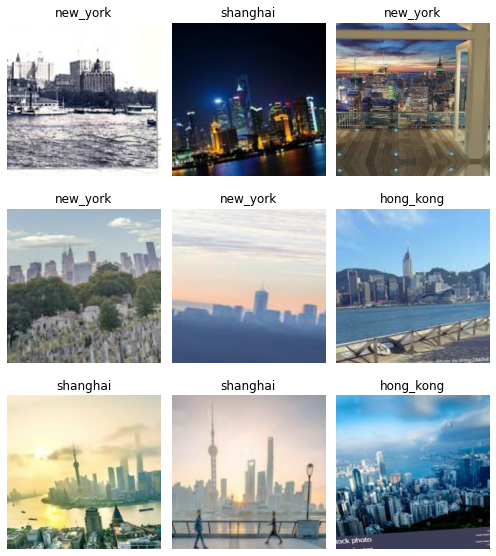

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="./", valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.classes
data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

# Train Model

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [17]:
learn.fit_one_cycle(15, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.146025,2.363780,0.325000,00:02
1,1.982598,1.410583,0.350000,00:02
2,1.803053,1.099712,0.550000,00:02
3,1.640200,1.030852,0.641667,00:02
4,1.433982,0.952640,0.666667,00:02
5,1.292085,0.898901,0.675000,00:02
6,1.156788,0.893740,0.691667,00:02
7,1.056190,0.893228,0.683333,00:02
8,0.955592,0.913684,0.691667,00:02
9,0.870257,0.883236,0.725000,00:02


In [18]:
learn.save('stage-1')

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


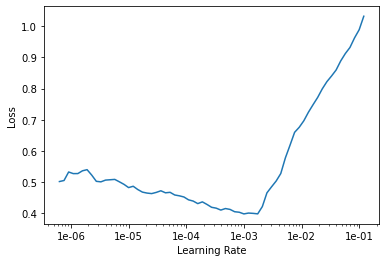

In [21]:
learn.recorder.plot()

In [31]:
learn.load('stage-1');

In [32]:
learn.fit_one_cycle(11, max_lr=slice(4e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.501119,0.837077,0.733333,00:03
1,0.489813,0.812614,0.741667,00:03
2,0.460034,0.761974,0.750000,00:03
3,0.402949,0.678527,0.750000,00:03
4,0.347447,0.600814,0.758333,00:03
5,0.312660,0.604140,0.791667,00:03
6,0.280807,0.602687,0.808333,00:03
7,0.256499,0.588603,0.800000,00:03
8,0.232844,0.577163,0.800000,00:03
9,0.209054,0.573474,0.800000,00:02


In [33]:
learn.save('stage-2')

# Interpretation

In [34]:
learn.load('stage-2');

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

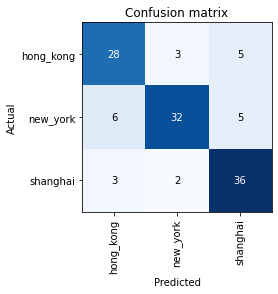

In [36]:
interp.plot_confusion_matrix()

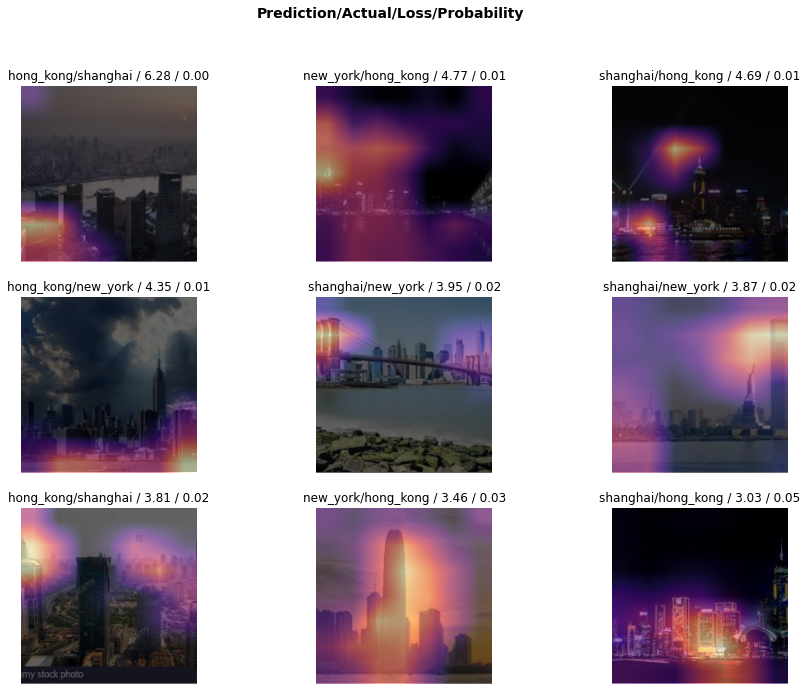

In [37]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

# Clean data

## Remove top losses

In [38]:
from fastai.widgets import *

In [39]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [40]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [41]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [42]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Remove duplicates

In [43]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [44]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [45]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [46]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [47]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Retrain Model

In [48]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [51]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [52]:
learn.fit_one_cycle(15, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.960744,1.675949,0.284483,00:02
1,1.809480,1.006631,0.560345,00:02
2,1.663898,0.762023,0.629310,00:02
3,1.470898,0.734716,0.689655,00:02
4,1.333343,0.682553,0.698276,00:02
5,1.198712,0.676626,0.715517,00:02
6,1.094452,0.626574,0.758621,00:02
7,0.989398,0.632524,0.758621,00:02
8,0.903735,0.646779,0.793103,00:02
9,0.818921,0.654019,0.784483,00:02


In [53]:
learn.save('stage-1')

In [54]:
learn.unfreeze()

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


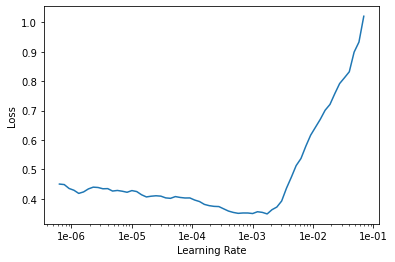

In [56]:
learn.recorder.plot()

In [65]:
learn.load('stage-1');

In [66]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.387690,0.633158,0.793103,00:03
1,0.394756,0.613873,0.801724,00:03
2,0.389539,0.633646,0.775862,00:03
3,0.365215,0.623494,0.775862,00:03
4,0.361076,0.590431,0.767241,00:03
5,0.330705,0.597860,0.775862,00:03
6,0.297935,0.612476,0.784483,00:03
7,0.276357,0.600604,0.784483,00:03
8,0.250509,0.596449,0.784483,00:03
9,0.241783,0.603379,0.784483,00:03


In [67]:
learn.save('stage-2')

# Interpretation

In [68]:
learn.load('stage-2');

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

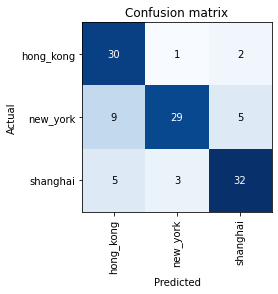

In [70]:
interp.plot_confusion_matrix()

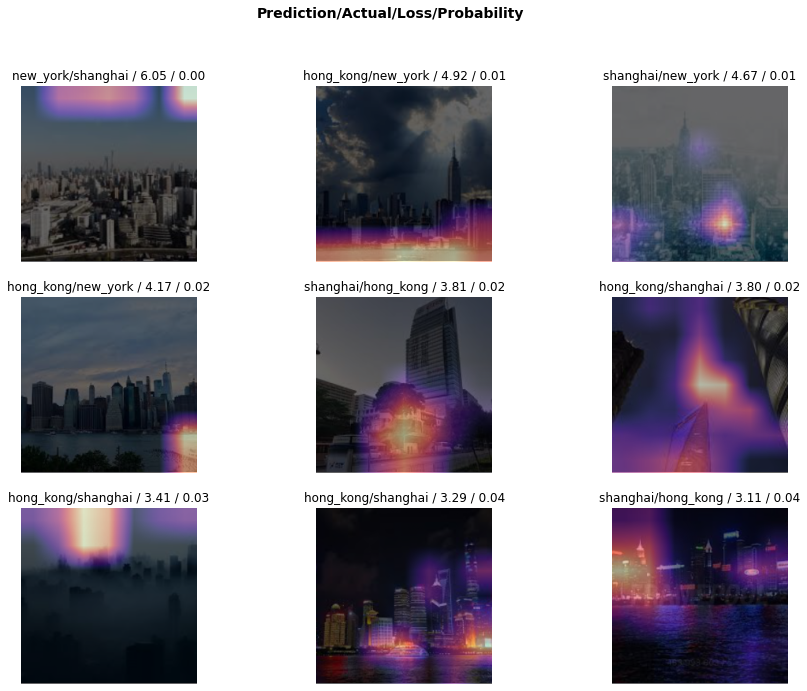

In [71]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

# Publish Model

## Export and predict with new image

In [72]:
learn.export()

In [73]:
defaults.device = torch.device('cpu')

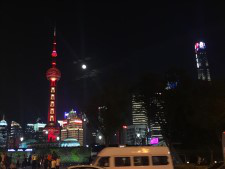

In [76]:
test_path = Path('data/city_skylines/test')
img = open_image(test_path/'shanghai.jpg')
img

In [77]:
learn = load_learner(path)

In [78]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category tensor(2), tensor(2), tensor([0.1293, 0.0023, 0.8684]))